In [1]:
!pip3 install numpy
!pip3 install pandas
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install cvxopt

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [3]:
# df = pd.read_csv('Datasets/bank-customer-churn-prediction.csv')
# df = pd.read_csv('Datasets/financial-risk-for-loan-approval.csv')
# df = pd.read_csv('Datasets/loan-approval-classification-dataset.csv')

# df = pd.read_csv('Datasets/campus-placement-prediction.csv')
# df = pd.read_csv('Datasets/predict-dropout-or-academic-success.csv')
df = pd.read_csv('Datasets/student-performance-dataset.csv')

# df = pd.read_csv('Datasets/fetal-health-classifiation.csv')
# df = pd.read_csv('Datasets/heart-disease-health-indicators-dataset.csv')
# df = pd.read_csv('Datasets/patient-treatment-classification.csv')

In [4]:
correlation_matrix = df.corr()

In [5]:
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                   StudentID       Age    Gender  Ethnicity  \
StudentID           1.000000 -0.042255 -0.014625  -0.012990   
Age                -0.042255  1.000000  0.044895  -0.028473   
Gender             -0.014625  0.044895  1.000000   0.016010   
Ethnicity          -0.012990 -0.028473  0.016010   1.000000   
ParentalEducation  -0.002307  0.025099  0.006771   0.033595   
StudyTimeWeekly     0.026976 -0.006800  0.011469   0.007184   
Absences            0.014841 -0.011511  0.021479  -0.025712   
Tutoring           -0.007834 -0.012076 -0.031597  -0.017440   
ParentalSupport     0.003016  0.033197  0.008065   0.020922   
Extracurricular    -0.003611 -0.025061 -0.005964  -0.008927   
Sports             -0.020703 -0.046320 -0.008897  -0.004484   
Music              -0.005468 -0.003492  0.007109  -0.014627   
Volunteering        0.008011  0.013074 -0.000200   0.013468   
GPA                -0.002697  0.000275 -0.013360   0.027760   
GradeClass         -0.098500 -0.006

In [6]:
class DBSCAN:
    def __init__(self, eps=1.0, minPts=5, equation='euclidean'):
        self.eps = eps # Radius for neighbourhood search
        self.minPts = minPts # Minimum number of points to form a cluster
        self.equation = equation
        
    def fit(self, dataframe):
        # Initialise labels array with -1
        self.labels = np.zeros(len(dataframe), dtype=int) - 1
        self.clusters = [] # List to hold all clusters
        cidx = 0 # Cluster ID counter
        for x in range(len(dataframe)):
            if self.labels[x] == -1:
                neighbours = self.get_neighbours(dataframe, x)
                if len(neighbours) < self.minPts:
                    self.labels[x] = 0 # Mark point as anomaly
                else:
                    cidx += 1
                    self.clusters.append([x])
                    self.labels[x] = cidx # Assign cluster ID to the point

                    # Exapnd the cluster with points
                    for y in neighbours:
                        if self.labels[y] == -1:
                            self.labels[y] = cidx
                            self.clusters[cidx-1].append(y)
                            neighbours2 = self.get_neighbours(dataframe, y)
                            if len(neighbours2) >= self.minPts:
                                neighbours += list(set(neighbours2) - set(neighbours))
                        elif self.labels[y] == 0:
                            self.labels[y] = cidx
                            self.clusters[cidx-1].append(y)
        return self.clusters

    def get_neighbours(self, dataframe, x):
        neighbours = set()
        # Iterate over all points to calculate distances
        for y in range(len(dataframe)):
            if self.distance(dataframe[x], dataframe[y]) <= self.eps: # Check if within eps distance
                neighbours.add(y)
        return list(neighbours)
    
    def distance(self, x, y):
        # Euclidean distance
        return np.sqrt(np.sum((x-y)**2))
                           

    def plot(self, data):
        # Create a 3D plot
        figure = plt.figure(figsize=(10, 8))
        ax = figure.add_subplot(111, projection='3d')

        # Find noise points and clusters
        noise_idx = np.where(self.labels == 0)[0]
        cluster_idxs = [np.array(c) for c in self.clusters]

        # Assign colours to clusters
        colours = cm.rainbow(np.linspace(0, 1, len(self.clusters) + 1))

        # Plot each cluster
        for i, cluster_idx in enumerate(cluster_idxs):
            ax.scatter(data[cluster_idx, 0], data[cluster_idx, 1], data[cluster_idx, 2], 
                       color=colours[i], s=10, label=f'Cluster {i + 1}')

        # Plot anomalies
        if len(noise_idx) > 0:
            ax.scatter(data[noise_idx, 0], data[noise_idx, 1], data[noise_idx, 2], 
                       color='black', s=10, label='Anomalies')

        # Add labels and legend
        ax.set_title("3D DBSCAN Clustering")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_zlabel("Feature 3")
        ax.legend()
        plt.show()

In [7]:
class OCSVM:
    def __init__(self, nu=0.1, kernel='rbf', gamma=1.0):
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma

    def _kernel_function(self, X, Y=None):
        # Computer the kernel matrix
        if Y is None:
            Y = X
        if self.kernel == 'rbf':
            # Radial basis function
            sq_dist = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
            return np.exp(-self.gamma * sq_dist)
        elif self.kernel == 'linear':
            # Linear kernel
            return np.dot(X, Y.T)
        elif self.kernel == 'poly':
            # Polynomial kernel
            return (np.dot(X, Y.T) + 1) ** 3
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X):
        n_samples = X.shape[0]
        K = self._kernel_function(X)

        # Define the quadratic programming problem
        P = matrix(K)
        q = matrix(-np.ones((n_samples, 1)))
        
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) / (self.nu * n_samples))))
        
        A = matrix(1.0, (1, n_samples)) # Equaltiy constraint
        b = matrix(1.0)

        # Solve quadratic programming problem
        sol = solvers.qp(P, q, G, h, A, b)

        # Extract Lagrange multipliers (alphas)
        alphas = np.array(sol['x']).flatten()
        support_vector_indices = alphas > 1e-5
        self.alphas = alphas[support_vector_indices]
        self.support_vectors = X[support_vector_indices]
        self.K_sv = K[support_vector_indices][:, support_vector_indices]
        
        # Compute the intercept term
        self.rho = np.mean(self.K_sv @ self.alphas)

    def decision_function(self, X):
        # Compute the decision function
        K_test = self._kernel_function(X, self.support_vectors)
        return np.sum(K_test * self.alphas, axis=1) - self.rho

    def predict(self, X):
        # Predict whether the data is an inlier or an outlier
        return np.sign(self.decision_function(X))
    
    
    def plot(self, X):
        predictions = self.predict(X)
        inliers = X[predictions == 1]
        outliers = X[predictions == -1]

        # Print IDs of outliers
        outlier_ids = np.where(predictions == -1)[0]
        print("Outlier IDs:", outlier_ids)

        plt.figure(figsize=(8, 6))
        plt.scatter(inliers[:, 0], inliers[:, 1], c='blue', label='Inliers', s=20)
        plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers', s=20)
        plt.title('One-Class SVM Results')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.grid(True)
        plt.show()

In [8]:
class IsolationTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.is_terminal = False
        self.size = 0

    def fit(self, X, depth=0):
        # Check the termination condition
        if depth >= self.max_depth or len(X) <= 1:
            self.is_terminal = True
            self.size = len(X)
            return

        # Randomly choose a feature and split value
        num_features = X.shape[1]
        self.split_feature = np.random.randint(0, num_features)
        min_val, max_val = np.min(X[:, self.split_feature]), np.max(X[:, self.split_feature])

        if min_val == max_val:  # No meaningful split
            self.is_terminal = True
            self.size = len(X)
            return

        self.split_value = np.random.uniform(min_val, max_val)

        # Partition the data
        left_mask = X[:, self.split_feature] < self.split_value # Mask for left subset
        right_mask = ~left_mask # Mask for right subset

        self.left = IsolationTree(self.max_depth)
        self.right = IsolationTree(self.max_depth)

        self.left.fit(X[left_mask], depth + 1)
        self.right.fit(X[right_mask], depth + 1)

    def path_length(self, X):
        path_lengths = np.zeros(X.shape[0])

        for i, x in enumerate(X):
            node = self
            depth = 0
            while not node.is_terminal: # Traverse tree until termianl node reached
                if x[node.split_feature] < node.split_value:
                    node = node.left
                else:
                    node = node.right
                depth += 1
            path_lengths[i] = depth + self._c(node.size)
        return path_lengths

    @staticmethod
    def _c(size):
        # Calculate average path length of a binary tree for given size
        if size <= 1:
            return 0
        return 2 * (np.log(size - 1) + 0.5772156649) - (2 * (size - 1) / size)


class IForest:
    def __init__(self, n_estimators=100, max_samples=256, max_depth=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.forest = []

    def fit(self, X):
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        n_samples, num_features = X.shape
        self.max_samples = min(self.max_samples, num_samples)
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(self.max_samples)))

        self.forest = []
        for _ in range(self.n_estimators):
            sample_indices = np.random.choice(num_samples, self.max_samples, replace=False)
            X_sample = X[sample_indices]
            tree = IsolationTree(self.max_depth)
            tree.fit(X_sample)
            self.forest.append(tree)

    def anomaly_score(self, X):
        # Convert DataFrame to NumPy array if needed
        if isinstance(X, pd.DataFrame):
            X = X.values

        path_lengths = np.zeros(X.shape[0])
        for tree in self.forest:
            path_lengths += tree.path_length(X)
        path_lengths /= len(self.forest)

        # Compute anomaly score based on path lengths
        c_n = 2 * (np.log(self.max_samples - 1) + 0.5772156649) - (2 * (self.max_samples - 1) / self.max_samples)
        scores = 2 ** (-path_lengths / c_n)
        return scores

    def predict(self, X, threshold=0.5):
        scores = self.anomaly_score(X)
        return np.where(scores > threshold, -1, 1)  # -1 for anomalies, 1 for normal

    def plot(self, X, predictions, feature_names=None):
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Assign colors for anomalies and inliers
        colors = np.array(['blue' if p == 1 else 'red' for p in predictions])
        plt.figure(figsize=(10, 6))

        if X.shape[1] == 2:  # If data has 2 features
            plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.8)
            plt.xlabel(feature_names[0])
            plt.ylabel(feature_names[1])
        else:  # For more than 2 features, plot only the first two
            plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.8)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        plt.title('Isolation Forest - Anomaly Detection')
        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers'),
                            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomalies')],
                   loc='upper right')
        plt.grid()
        plt.show()

In [9]:
continuous_ratio_threshold = 2  # Customize based on the dataset characteristics

# Function to identify unique ID column
def identify_unique_id(df):
    unique_id_column = []
    for col in df.columns:
        if (
            df[col].nunique() == len(df)  # Unique values equal to the number of rows
            and not pd.api.types.is_float_dtype(df[col])  # Exclude float columns
        ):
            # Calculate range-to-unique ratio for integer columns
            if pd.api.types.is_integer_dtype(df[col]):
                col_range = df[col].max() - df[col].min() + 1
                if col_range / df[col].nunique() > continuous_ratio_threshold:
                    continue  # Likely a continuous integer column, not an ID
            unique_id_column = col
    return unique_id_column

# Identify the unique ID column
unique_id_column = identify_unique_id(df)

print("Unique ID column(s):", unique_id_column)

Unique ID column(s): StudentID


In [10]:
if unique_id_column:
    df.drop(columns=[unique_id_column], inplace=True)

In [11]:
used_cols = [col for col in df.columns if df[col].nunique() > 25]
print(used_cols)

['StudyTimeWeekly', 'Absences', 'GPA']


     pcost       dcost       gap    pres   dres
 0: -9.3927e-01 -1.0118e+02  5e+03  3e+01  4e-16
 1: -9.3436e-01 -9.3543e+01  1e+02  4e-01  2e-16
 2: -9.2008e-01 -5.7494e+00  5e+00  2e-16  8e-16
 3: -9.2149e-01 -1.3268e+00  4e-01  3e-15  1e-15
 4: -9.2786e-01 -1.1381e+00  2e-01  4e-16  8e-17
 5: -9.3213e-01 -9.8188e-01  5e-02  6e-16  1e-16
 6: -9.3459e-01 -9.7080e-01  4e-02  3e-15  9e-17
 7: -9.3609e-01 -9.6090e-01  2e-02  3e-15  8e-17
 8: -9.3781e-01 -9.4712e-01  9e-03  4e-16  6e-17
 9: -9.3884e-01 -9.4238e-01  4e-03  5e-16  6e-17
10: -9.3926e-01 -9.4098e-01  2e-03  5e-16  6e-17
11: -9.3944e-01 -9.4051e-01  1e-03  1e-15  7e-17
12: -9.3964e-01 -9.4008e-01  4e-04  2e-15  6e-17
13: -9.3972e-01 -9.3995e-01  2e-04  7e-16  7e-17
14: -9.3979e-01 -9.3985e-01  6e-05  7e-16  7e-17
15: -9.3981e-01 -9.3983e-01  2e-05  6e-16  6e-17
16: -9.3982e-01 -9.3982e-01  2e-06  3e-15  7e-17
17: -9.3982e-01 -9.3982e-01  2e-07  4e-15  8e-17
Optimal solution found.
Outlier IDs: [  54  442  686 1327 1415 1866 21

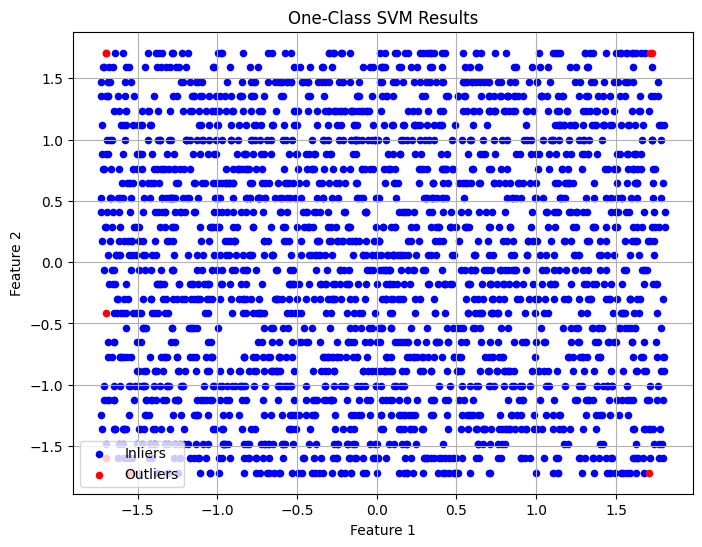

Predictions: [1. 1. 1. ... 1. 1. 1.]
     pcost       dcost       gap    pres   dres
 0: -9.4528e-01 -1.0116e+02  5e+03  3e+01  4e-16
 1: -9.3998e-01 -9.3519e+01  1e+02  4e-01  2e-16
 2: -9.2294e-01 -6.8525e+00  6e+00  4e-03  8e-16
 3: -9.2241e-01 -1.4529e+00  5e-01  4e-04  1e-15
 4: -9.2691e-01 -1.4023e+00  5e-01  2e-04  7e-16
 5: -9.2388e-01 -1.3711e+00  4e-01  1e-04  4e-16
 6: -9.3227e-01 -1.0959e+00  2e-01  4e-05  2e-16
 7: -9.3334e-01 -1.0941e+00  2e-01  4e-05  2e-16
 8: -9.3840e-01 -1.0431e+00  1e-01  2e-05  1e-16
 9: -9.4198e-01 -9.9750e-01  6e-02  8e-16  7e-17
10: -9.4428e-01 -9.6968e-01  3e-02  3e-16  6e-17
11: -9.4622e-01 -9.5447e-01  8e-03  9e-16  7e-17
12: -9.4672e-01 -9.5194e-01  5e-03  4e-15  7e-17
13: -9.4729e-01 -9.4887e-01  2e-03  1e-15  6e-17
14: -9.4742e-01 -9.4852e-01  1e-03  2e-16  7e-17
15: -9.4760e-01 -9.4799e-01  4e-04  4e-16  6e-17
16: -9.4768e-01 -9.4783e-01  2e-04  1e-15  7e-17
17: -9.4768e-01 -9.4783e-01  1e-04  2e-15  6e-17
18: -9.4771e-01 -9.4780e-01  9e-0

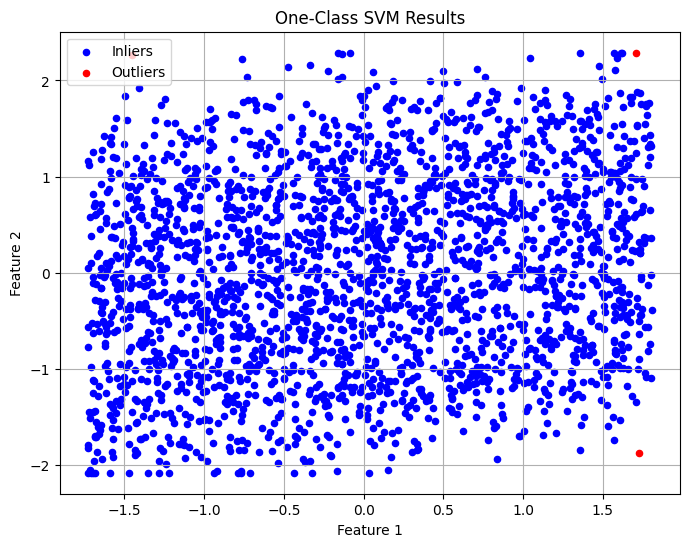

Predictions: [1. 1. 1. ... 1. 1. 1.]
     pcost       dcost       gap    pres   dres
 0: -9.1864e-01 -1.0119e+02  5e+03  3e+01  4e-16
 1: -9.1130e-01 -9.3548e+01  1e+02  4e-01  3e-16
 2: -8.7684e-01 -7.0146e+00  6e+00  4e-03  7e-16
 3: -8.7652e-01 -1.4521e+00  6e-01  4e-04  1e-15
 4: -8.8704e-01 -1.3312e+00  4e-01  2e-04  5e-16
 5: -8.9647e-01 -1.0684e+00  2e-01  6e-05  2e-16
 6: -8.9852e-01 -1.0621e+00  2e-01  5e-05  2e-16
 7: -9.0414e-01 -1.0241e+00  1e-01  3e-05  1e-16
 8: -9.0600e-01 -9.9607e-01  9e-02  5e-06  8e-17
 9: -9.1320e-01 -9.5309e-01  4e-02  1e-06  1e-16
10: -9.1557e-01 -9.4268e-01  3e-02  3e-07  8e-17
11: -9.1649e-01 -9.3812e-01  2e-02  2e-07  7e-17
12: -9.1817e-01 -9.3097e-01  1e-02  4e-08  8e-17
13: -9.1929e-01 -9.2708e-01  8e-03  2e-08  7e-17
14: -9.2015e-01 -9.2446e-01  4e-03  7e-09  7e-17
15: -9.2081e-01 -9.2231e-01  1e-03  2e-10  8e-17
16: -9.2089e-01 -9.2210e-01  1e-03  1e-10  7e-17
17: -9.2116e-01 -9.2152e-01  4e-04  3e-11  9e-17
18: -9.2122e-01 -9.2140e-01  2e-0

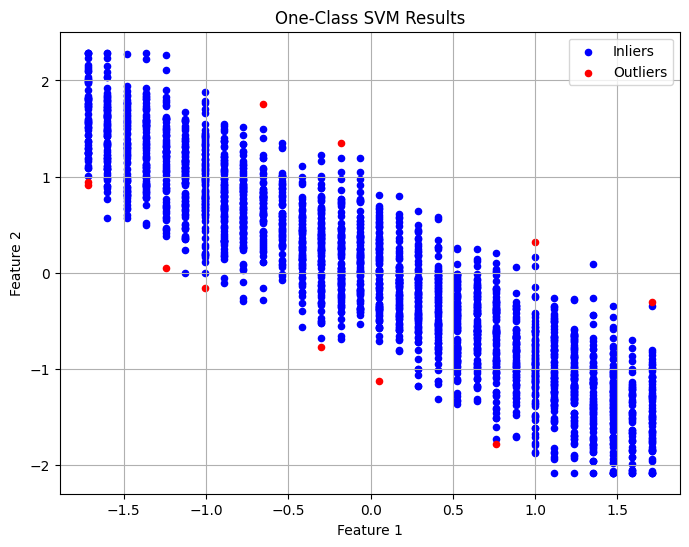

Predictions: [1. 1. 1. ... 1. 1. 1.]


In [13]:
for i in range(len(used_cols)):
    for j in range(i+1, len(used_cols)):
        data = df[[used_cols[i], used_cols[j]]]
        data_norm = StandardScaler().fit_transform(data)
        
        # Train custom One-Class SVM
        oc_svm = OCSVM(nu=0.01, kernel='rbf', gamma=1)
        oc_svm.fit(data_norm)
        oc_svm.plot(data_norm)
        
        # Predict on training data_norm
        predictions = oc_svm.predict(data_norm)
        print("Predictions:", predictions)

In [14]:
def inew():
    print ("jsjs")